### satGEM 
* figure out how to work with the satGEM data
    * works using h5py module to load sections of satGEM as necessary.
* compare satGEM data with transect observations to see how similar they are

** questions **
-  Check equations
- go over wave action
- how do i present the energy found in the observed waves (momentum fluxes, total internal energy, energy flux?)
- should i use the whole dispersion relation instead of assuming that 

In [6]:
# load in data and similarly located satGEM data
%matplotlib inline
import numpy as np
import scipy.signal as sig
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import data_load
import gsw
import oceans as oc
import pandas as pd
import internal_waves_calculations as iwc
import warnings
import cmocean
import matplotlib.colors as colors
import ray_tracing_satGEM as rt
import h5py
from datetime import datetime, timedelta
# Probably Shouldn't do this but they annoy me
warnings.simplefilter("ignore")

pd.options.display.max_rows = 3000
pd.options.display.max_columns = 22

plt.rcParams.update({'font.size':14})


# load data and cut off bottom (its all nans)
ladcp, ctd = data_load.load_data()
# strain = np.genfromtxt('strain.csv', delimiter=',')
wl_max = 1000
wl_min = 400
ctd_bin_size = 1024
ladcp_bin_size = 1024
nfft = 1024
U, V, p_ladcp = oc.loadLADCP(ladcp)
S, T, p_ctd, lat, lon = oc.loadCTD(ctd)
rho = gsw.density.rho(S, T, p_ctd)

maxDepth = 4000
idx_ladcp = p_ladcp[:, -1] <= maxDepth
idx_ctd = p_ctd[:, -1] <= maxDepth


S = S[idx_ctd,:]
T = T[idx_ctd,:]
rho = rho[idx_ctd,:]
p_ctd = p_ctd[idx_ctd, :]
U = U[idx_ladcp, :]
V = V[idx_ladcp, :]
p_ladcp = p_ladcp[idx_ladcp, :]


# Bin CTD data
ctd_bins = oc.binData(S, p_ctd[:, 0], ctd_bin_size)
# Bin Ladcp Data
ladcp_bins = oc.binData(U, p_ladcp[:, 0], ladcp_bin_size)

# Depth and lat/long grids (For plots)
depths = np.vstack([np.nanmean(p_ctd[binIn]) for binIn in ctd_bins])
dist = gsw.distance(lon, lat)
dist = np.cumsum(dist)/1000
dist = np.append(0,dist)

In [185]:
# load satGEM
gem = rt.satGEM_field()

# find lats and lons of transect in satGEM
lat_ids = np.array([np.argmin(np.abs(latIn - gem.lat[:])) for latIn in lat.flatten()])
lon_ids = np.array([np.argmin(np.abs(lonIn - gem.lon[:])) for lonIn in lon.flatten()])


# find mean date the sat gem time spacing is by week so this shouldnt be a problem just for checking 
dates = np.genfromtxt('dates.csv', delimiter=',')
dates = dates[38:62, :]
date_mean = np.mean(dates, axis=0).astype(int)
date_mean = datetime(date_mean[0], date_mean[1], date_mean[2], date_mean[3], date_mean[4], date_mean[5])

time_idx = np.argmin((np.abs(date_mean - gem.time)))

temp_gem = np.array([ np.array(gem.temp[lon_id, lat_id, :, 
                                         time_idx]) for lon_id, lat_id in zip(lon_ids, lat_ids)]).T
temp_gem = np.flipud(temp_gem)
gem_depths = np.flipud(np.array(gem.depth_grid[:]))

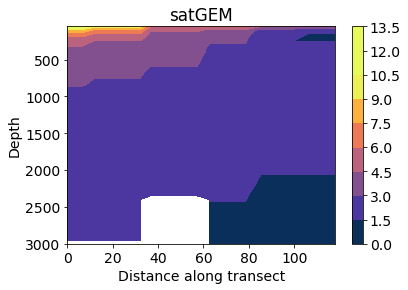

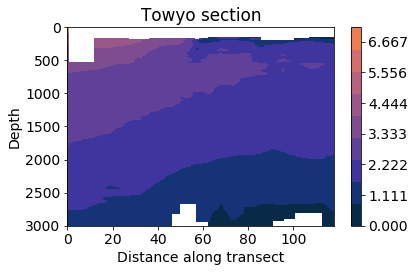

In [187]:
norm = colors.Normalize(vmin=0.,vmax=10)

plt.figure()
plt.contourf(dist.flatten(), gem_depths.flatten(),
             temp_gem, cmap=cmocean.cm.thermal,
            norm=norm)
plt.gca().invert_yaxis()
v = np.linspace(0, 10, 10, endpoint=True)
plt.colorbar()
plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title('satGEM')

plt.figure()
plt.contourf(dist.flatten(), p_ctd[:,0], T, cmap=cmocean.cm.thermal, vmin=0, vmax=10, norm = norm)
v = np.linspace(0, 10, 10, endpoint=True)
plt.colorbar(ticks=v, extend='max')

plt.xlabel('Distance along transect')
plt.ylabel('Depth')
plt.title('Towyo section')
plt.ylim(0,3000)
plt.gca().invert_yaxis()
plt.tight_layout()



In [189]:
# check velocities and N2